In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
from tabulate import tabulate

In [2]:
# loading images
img1 = Image.open('misc/5.2.10.tiff')
img2 = Image.open('misc/boat.512.tiff')
img3 = Image.open('misc/5.3.01.tiff')
lighthouse = Image.open('lighthouse.png')
lighthouse = lighthouse.convert('L')
template = Image.open('template.png')
template = template.convert('L')

In [3]:
#  linear convolution implemetation
def dft(I):
    I = np.array(I)
    m, n = I.shape
    W_m = np.zeros((m, m), dtype=np.complex128)  
    W_n = np.zeros((n, n), dtype=np.complex128) 

    for i in range(m):
        for j in range(m):
            W_m[i, j] = np.exp(-2j*np.pi*i*j/m)

    for i in range(n):
        for j in range(n):
            W_n[i, j] = np.exp(-2j*np.pi*i*j/n)

    F_I = W_m @ I @ W_n
    return F_I

def idft(F_I):
    m, n = F_I.shape
    max_val = max(n, m)
    W_m = np.zeros((m, m), dtype=np.complex128)  
    W_n = np.zeros((n, n), dtype=np.complex128)  

    for i in range(m):
        for j in range(m):
            W_m[i, j] = np.exp(2j*np.pi*i*j/m)

    for i in range(n):
        for j in range(n):
            W_n[i, j] = np.exp(2j*np.pi*i*j/n)

    I = W_m @ F_I @ W_n
    I = I / (m * n)
    return I

def circular_conloution_freq(I, H):
    pad_rows = I.shape[0] - H.shape[0]
    pad_cols = I.shape[1] - H.shape[1]
    padded_H = np.pad(H, ((0, pad_rows), (0, pad_cols)), mode='constant')
    J = idft(dft(I) * dft(padded_H))
    return J.real

def linear_convolution_freq(I, H):
    n, m = I.shape[0], I.shape[1]
    n1, m1 = H.shape[0],H.shape[1]
    padded_I = np.pad(I, ((0, n), (0, m)), mode='constant')
    padded_H = np.pad(H, ((0, n1), (0,m1)), mode='constant')
    J = circular_conloution_freq(padded_I, padded_H)
    return J[:(n+n1-1), :(m + m1 - 1)]

## Q1

### 1

In [4]:
def mse(I1, I2):
    if I1.shape != I2.shape:
        raise ValueError("Input images must have the same shape")
        return
    return ((I1-I2)**2).mean()

In [5]:
def psnr(I1, I2):
    if I1.shape != I2.shape:
        raise ValueError("Input images must have the same shape")
    mse_ = mse(I1, I2) 
    L = 255
    if mse_ == 0:
        return float('inf')  
    return 10 * np.log10(L**2 / mse_)

### 2

In [6]:
def func(k1,k2,c):
    return (2 * k1 * k2 + c)/(k1**2 + k2**2 + c)

def gaussian_filter(size, sigma):
    x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    gaussian_filter = np.exp(-(x*x + y*y)/(2.0 * sigma ** 2))
    return gaussian_filter / np.sum(gaussian_filter)


In [7]:
def SSIM(img1, img2, size, sigma=1):
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same shape")

    I1 = img1.copy()
    I2 = img2.copy()
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2
    C3 = C2 / 2

    filt = gaussian_filter(size, sigma)
    pad = size // 2
    I1_padded = np.pad(I1, pad, mode='constant')
    I2_padded = np.pad(I2, pad, mode='constant')
    ssim = 0
    for i in range(pad, I1.shape[0] + pad):
        for j in range(pad, I1.shape[1] + pad):
            I1_temp = I1_padded[i - pad: i + pad + 1, j - pad: j + pad + 1]
            I2_temp = I2_padded[i - pad: i + pad + 1, j - pad: j + pad + 1]

            mu_I1 = np.sum(I1_temp * filt)
            mu_I2 = np.sum(I2_temp * filt)
            sigma_I1 = np.sqrt(np.sum((I1_temp - mu_I1) ** 2 * filt))
            sigma_I2 = np.sqrt(np.sum((I2_temp - mu_I2) ** 2 * filt))
            sigma_I12 = np.sum((I1_temp - mu_I1) * (I2_temp - mu_I2) * filt)

            ssim += func(mu_I1,mu_I2,C1)*func(sigma_I1,sigma_I2,C2)*((sigma_I12 + C3)/(sigma_I1*sigma_I2 + C3))

    return ssim / (I1.shape[0] * I1.shape[1])

#### generating distortions

### 1

In [8]:
def mean_shift(img, shift):
    J = img + shift
    J = np.clip(J, 0, 255)
    return J

### 2

In [9]:
def awgn(img, mean=0, sigma=16):
    noise = np.random.normal(mean,sigma,size=img.shape)
    return img + noise

### 3

In [10]:
def jpeg_comp(img, quality=10):
    cv2.imwrite('jpg_temp.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    compressed_img = cv2.imread('jpg_temp.jpg', cv2.IMREAD_GRAYSCALE)
    compressed_img = cv2.resize(compressed_img, (img.shape[1], img.shape[0]))
    os.remove('jpg_temp.jpg')
    return compressed_img

### 4

In [11]:
def gaussian_blur(img,size,sigma=2):
    filt = gaussian_filter(size,sigma)
    result = linear_convolution_freq(img,filt) 
    return  result[:img.shape[0], :img.shape[1]]

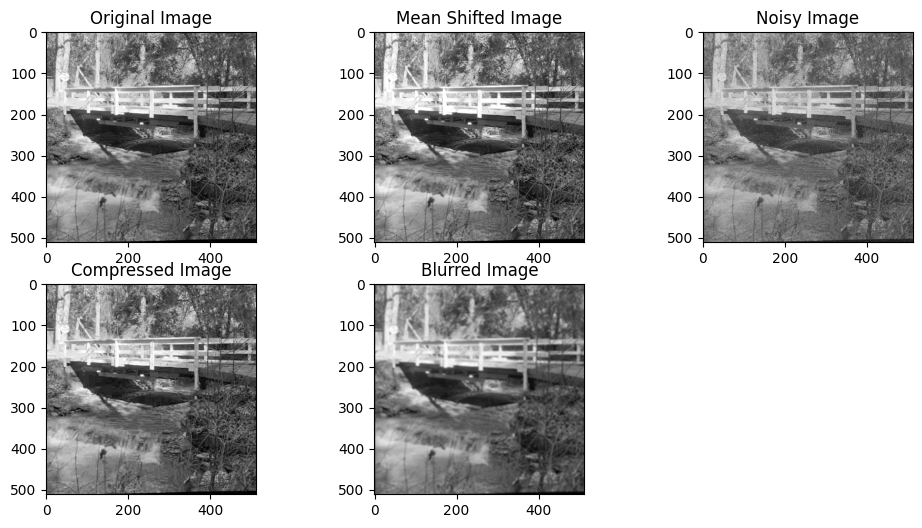

╒══════════════════╤═══════╤════════╤════════╕
│ Image            │   MSE │   PSNR │   SSIM │
╞══════════════════╪═══════╪════════╪════════╡
│ Mean Shifted     │ 254.1 │  24.08 │   0.98 │
├──────────────────┼───────┼────────┼────────┤
│ White Noisy      │ 255.2 │  24.06 │   0.58 │
├──────────────────┼───────┼────────┼────────┤
│ JPEG Compressed  │ 199.7 │  25.13 │   0.62 │
├──────────────────┼───────┼────────┼────────┤
│ Gaussian Blurred │ 698.8 │  19.69 │   0.42 │
╘══════════════════╧═══════╧════════╧════════╛


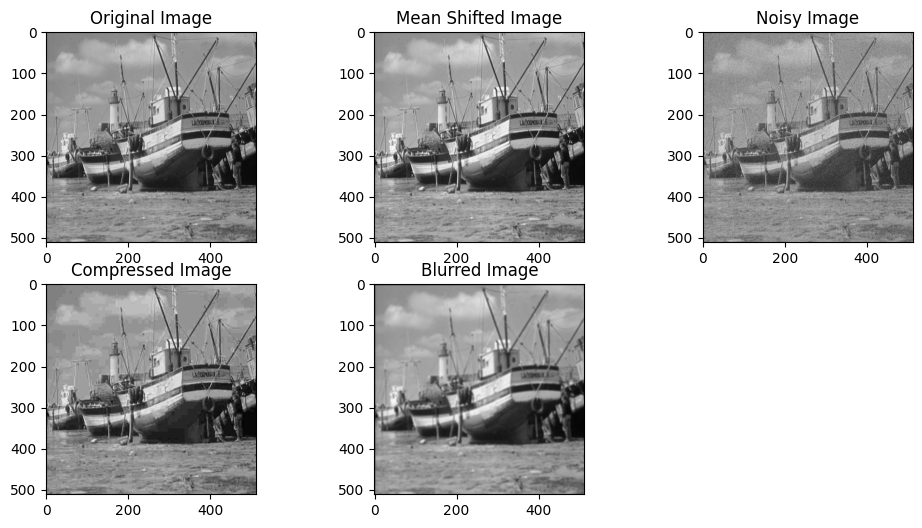

╒══════════════════╤════════╤════════╤════════╕
│ Image            │    MSE │   PSNR │   SSIM │
╞══════════════════╪════════╪════════╪════════╡
│ Mean Shifted     │ 255.95 │  24.05 │   0.98 │
├──────────────────┼────────┼────────┼────────┤
│ White Noisy      │ 255.16 │  24.06 │   0.44 │
├──────────────────┼────────┼────────┼────────┤
│ JPEG Compressed  │  99.91 │  28.13 │   0.73 │
├──────────────────┼────────┼────────┼────────┤
│ Gaussian Blurred │ 507.48 │  21.08 │   0.61 │
╘══════════════════╧════════╧════════╧════════╛


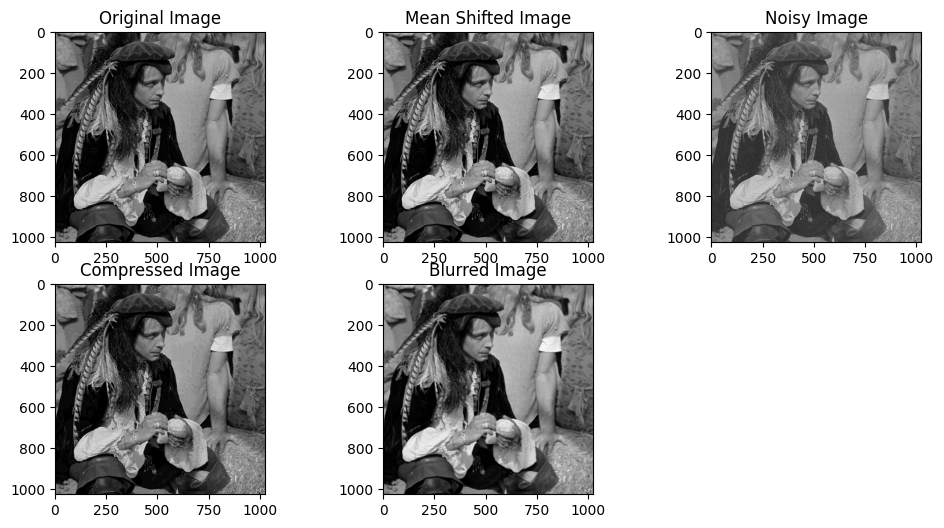

╒══════════════════╤════════╤════════╤════════╕
│ Image            │    MSE │   PSNR │   SSIM │
╞══════════════════╪════════╪════════╪════════╡
│ Mean Shifted     │ 255.98 │  24.05 │   0.89 │
├──────────────────┼────────┼────────┼────────┤
│ White Noisy      │ 255.73 │  24.05 │   0.4  │
├──────────────────┼────────┼────────┼────────┤
│ JPEG Compressed  │  80.67 │  29.06 │   0.73 │
├──────────────────┼────────┼────────┼────────┤
│ Gaussian Blurred │ 350.9  │  22.68 │   0.64 │
╘══════════════════╧════════╧════════╧════════╛


In [12]:
#testing 
def test(I1,I2):
    return mse(I1,I2), psnr(I1,I2) , SSIM(I1,I2,3)

images_to_test = [img1,img2,img3]

for idx, img in enumerate(images_to_test):
    img = np.array(img).astype(np.int32)
    mean_shifted_img = mean_shift(img,16)
    noisy_img = awgn(img)
    compressed_img = jpeg_comp(img)
    blurred_img = gaussian_blur(img,5)
    
    mse_mean_shift, psnr_mean_shift, ssim_mean_shift = test(img, mean_shifted_img)
    mse_noisy, psnr_noisy, ssim_noisy = test(img, noisy_img)
    mse_compressed, psnr_compressed, ssim_compressed = test(img, compressed_img)
    mse_blurred, psnr_blurred, ssim_blurred = test(img, blurred_img)

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 3, 1)
    plt.imshow(img,cmap = 'gray')
    plt.title('Original Image')

    plt.subplot(2, 3, 2)
    plt.imshow(mean_shifted_img,cmap = 'gray')
    plt.title('Mean Shifted Image')

    plt.subplot(2, 3, 3)
    plt.imshow(noisy_img,cmap = 'gray')
    plt.title('Noisy Image')
   
    plt.subplot(2, 3, 4)
    plt.imshow(compressed_img,cmap = 'gray')
    plt.title('Compressed Image')

    plt.subplot(2, 3, 5)
    plt.imshow(blurred_img,cmap = 'gray')
    plt.title('Blurred Image')
    plt.show()
    
    data = [["Mean Shifted ", f"{mse_mean_shift:.2f}", f"{psnr_mean_shift:.2f}", f"{ssim_mean_shift:.2f}"],
        ["White Noisy ", f"{mse_noisy:.2f}", f"{psnr_noisy:.2f}", f"{ssim_noisy:.2f}"],
        ["JPEG Compressed ", f"{mse_compressed:.2f}", f"{psnr_compressed:.2f}", f"{ssim_compressed:.2f}"],
        ["Gaussian Blurred ", f"{mse_blurred:.2f}", f"{psnr_blurred:.2f}", f"{ssim_blurred:.2f}"]]
    headers = ["Image", "MSE", "PSNR", "SSIM"]
    print(tabulate(data, headers=headers, tablefmt="fancy_grid"))

#### My ratings:
* Bridge = [0.9,0.7,0.8,0.3]
* Boat = [0.9,0.4,0.8,0.5]
* person = [0.9,0.5,0.8,0.7]

<p>We can see the human persion matches with the SSIM score in terms of order but its not same with psnr so SSIM is a good metric compared to PSNR </p>

In [13]:
def correlation(arr1, arr2):
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    mean_arr1 = np.mean(arr1)
    mean_arr2 = np.mean(arr2)
    covariance = np.average((arr1 - mean_arr1) * (arr2 - mean_arr2))
    std_arr1 = np.std(arr1)
    std_arr2 = np.std(arr2)
    return covariance / (std_arr1 * std_arr2)

print(f'coorelation PSNR-bridge:{correlation([24.08,24.05,25.13,19.63],[0.9,0.7,0.8,0.3])} , SSIM-bridge{correlation([0.98,0.58,0.62,0.42],[0.9,0.7,0.8,0.3])}')
print(f'coorelation PSNR-boat:{correlation([24.05,24.06,28.13,21.08],[0.9,0.4,0.8,0.5])} , SSIM-boat{correlation([0.98,0.44,0.73,0.61],[0.9,0.4,0.8,0.5])}')
print(f'coorelation PSNR-person:{correlation([24.05,24.06,29.06,22.68], [0.9,0.5,0.8,0.7])} , SSIM-person{correlation([0.89,0.4,0.73,0.64],[0.9,0.5,0.8,0.7])}')

    

coorelation PSNR-bridge:0.9319074388441516 , SSIM-bridge0.8311619254760775
coorelation PSNR-boat:0.5101832513694016 , SSIM-boat0.9437614319107477
coorelation PSNR-person:0.28346976167159643 , SSIM-person0.9964250224282102


<p>we can see in most cases human perception directly correlates with SSIM but not always with PSNR </p>

## Q2

In [14]:
noised_lighthouse = awgn(np.array(lighthouse).astype('int'),0,10)

## 2.1

In [15]:
class GradientEdgeDetector:
    def __init__(self):
        self.Centered = [np.array([[0,0,0],[-0.5, 0, 0.5],[0,0,0]]), np.array([[0,-0.5,0],[0,0,0],[0,0.5,0]])]
        self.Roberts = [np.array([[1, 0], [0, -1]]), np.array([[0, 1], [-1, 0]])]
        self.Prewitt = [np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]), np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])]
        self.Sobel = [np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]), np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])]

    def L2(self, I_x, I_y):
        return np.sqrt(np.square(I_x) + np.square(I_y))

    def L1(self, I_x, I_y):
        return np.abs(I_x) + np.abs(I_y)

    def Linf(self, I_x, I_y):
        return np.maximum(np.abs(I_x), np.abs(I_y))

    def threshold(self, I, const):
        return np.where(I >= const, 1, 0)

    def apply(self, I, gradient, norm, threshold_value):
        if gradient == 'centered':
            kernel_x, kernel_y = self.Centered[0], self.Centered[1]
        elif gradient == 'roberts':
            kernel_x, kernel_y = self.Roberts[0], self.Roberts[1]
        elif gradient == 'prewitt':
            kernel_x, kernel_y = self.Prewitt[0], self.Prewitt[1]
        elif gradient == 'sobel':
            kernel_x, kernel_y = self.Sobel[0], self.Sobel[1]
        else:
            raise ValueError("Invalid gradient type")

        temp_x = linear_convolution_freq(I, kernel_x)
        temp_y = linear_convolution_freq(I, kernel_y)
        grad = norm(temp_x, temp_y)
        thresholded = self.threshold(grad, threshold_value)
        return grad,thresholded

In [16]:
def display_side_by_side(images, titles):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(10,8))
    for i in range(num_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(titles[i])
        axes[i].axis('off')
    plt.show()

In [17]:
ged = GradientEdgeDetector()

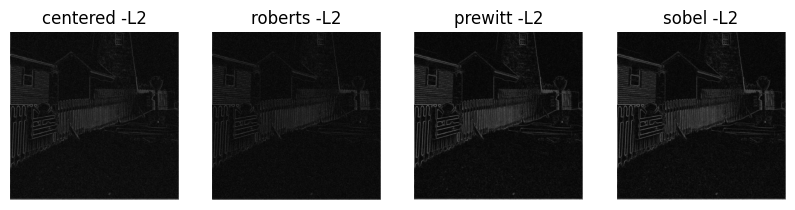

In [18]:
gradient_types = ['centered', 'roberts', 'prewitt', 'sobel']
norm_function = ged.L2

results = []
titles = []

for gradient_type in gradient_types:
    temp,_ = ged.apply(noised_lighthouse, gradient_type, norm_function,0.5)
    results.append(temp)
    titles.append(f"{gradient_type} -L2")

display_side_by_side(results, titles)

for the noisy lighthouse from the above we can see that sobel and prewitt did a much better job at identifing the edges compared to centers and roberts

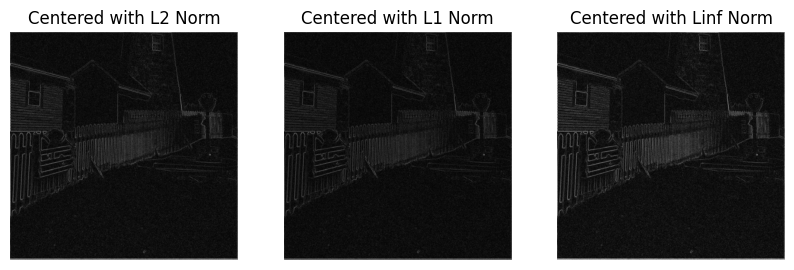

In [20]:
norm_functions = [ged.L2, ged.L1, ged.Linf]
gradient_type = 'centered'

results = []
titles = []

for norm_function in norm_functions:
    temp,_ = ged.apply(noised_lighthouse, gradient_type, norm_function,0.5)
    results.append(temp)
    titles.append(f"Centered with {norm_function.__name__} Norm")

display_side_by_side(results, titles)

143.31052204042555 4.151986619471322e-12
143.31052204042555 4.151986619471322e-12
143.31052204042555 4.151986619471322e-12


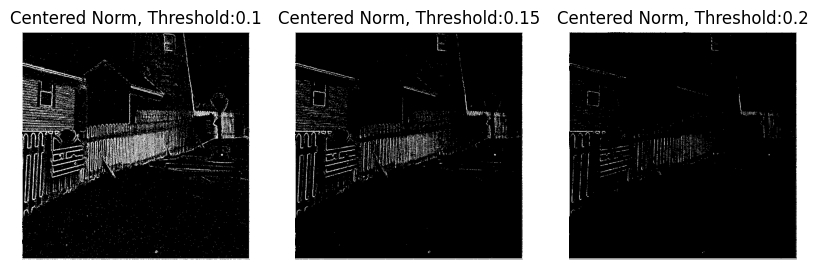

In [35]:
threshold_values = [0.1,0.15,0.2] 
results = []
titles = []

for threshold_value in threshold_values:
    temp,thresholded_edges = ged.apply(noised_lighthouse, gradient_type, norm_function, threshold_value*255)
    print(np.max(temp),np.min(temp))
    results.append(thresholded_edges)
    titles.append(f"Centered Norm, Threshold:{threshold_value}")
    
display_side_by_side(results, titles)

<p>as threashold increases we only see dominant edges</p>

## 2.2

In [22]:
class LaplacianEdgeDetector:
    
    def ZC_detector(self, image):
        zc = np.zeros_like(image)
        for i in range(image.shape[0]-1):
            for j in range(image.shape[1]-1):
                if image[i][j] > 0:
                    if image[i+1][j] < 0 or image[i+1][j+1] < 0 or image[i][j+1] < 0:
                        zc[i,j] = 1
                elif image[i][j] < 0:
                    if image[i+1][j] > 0 or image[i+1][j+1] > 0 or image[i][j+1] > 0:
                        zc[i,j] = 1
        return zc
        
    def apply(self, image):
        kernel = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])
        laplacian_image = linear_convolution_freq(image, kernel)
        zero_crossing_image = self.ZC_detector(laplacian_image)
        return laplacian_image,zero_crossing_image
    

In [23]:
led = LaplacianEdgeDetector()

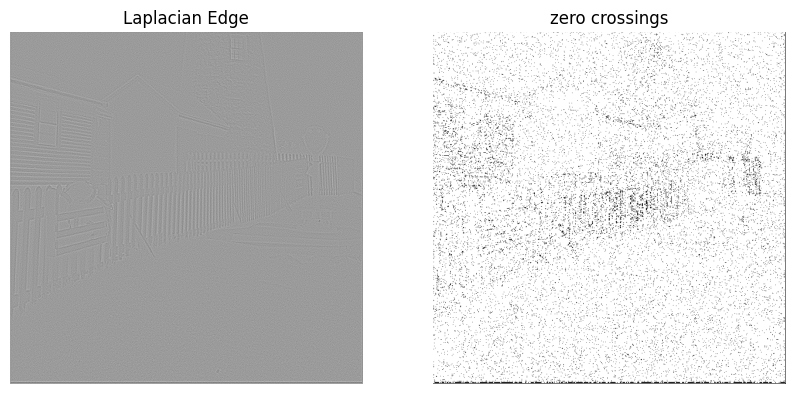

In [24]:
laplacian_image,zc = led.apply(noised_lighthouse)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(laplacian_image, cmap='gray')
plt.title("Laplacian Edge")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(zc, cmap='gray')
plt.title("zero crossings")
plt.axis('off')
plt.show()

## 2.3

In [25]:
class LOG:
    
    def ZC_detector(self, image):
        zc = np.zeros_like(image)
        for i in range(image.shape[0]-1):
            for j in range(image.shape[1]-1):
                if image[i][j] > 0:
                    if image[i+1][j] < 0 or image[i+1][j+1] < 0 or image[i][j+1] < 0:
                        zc[i,j] = 1
                elif image[i][j] < 0:
                    if image[i+1][j] > 0 or image[i+1][j+1] > 0 or image[i][j+1] > 0:
                        zc[i,j] = 1
        return zc
        
    def apply(self, image, size=5, sigma=1):
        kernel = gaussian_filter(size,sigma)
        lp = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])
        lp = lp/8
        kernel = linear_convolution_freq(kernel,lp)
        laplacian_image = linear_convolution_freq(image, kernel)
        zero_crossing_image = self.ZC_detector(laplacian_image)
        return zero_crossing_image

In [26]:
log = LOG()

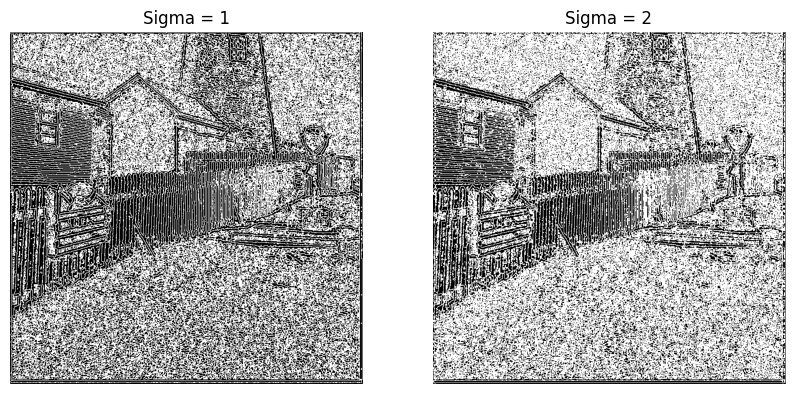

In [27]:
sigma_values = [1,2]
results = []
titles = []

for s in sigma_values:
    temp = log.apply(noised_lighthouse, sigma=s)
    results.append(temp)
    titles.append(f"Sigma = {s}")

display_side_by_side(results, titles)

<p>we have applied 3 diferent types of filters for the lighthouse image for which noie is added we can see the gradient and laplacian are sensitive to the noise compared to laplacian of gaussian where the effect of noise is reduced as sigma of LoG increased but along with this the less significant edged are also supressed in the edge map </p>

## Q3

### 1

In [28]:
def norm_corr(I, T):
    p, q = T.shape
    m, n = I.shape
    J = np.zeros((m, n))
    padded_I = np.zeros((m + p - 1,n + q - 1))
    padded_I[p-1:m+p-1,q-1:n+q-1] = I
    tempEng = np.sum(T**2)
    for i in range(m):
        for j in range(n):
            temp = padded_I[i:i+p,j:j+q]
            imgEng = np.sum(temp ** 2)
            if tempEng*imgEng != 0:
                J[i, j] = np.sum(temp * T)/np.sqrt(tempEng*imgEng)
            else:
                J[i,j] = 0
            
    return J*255

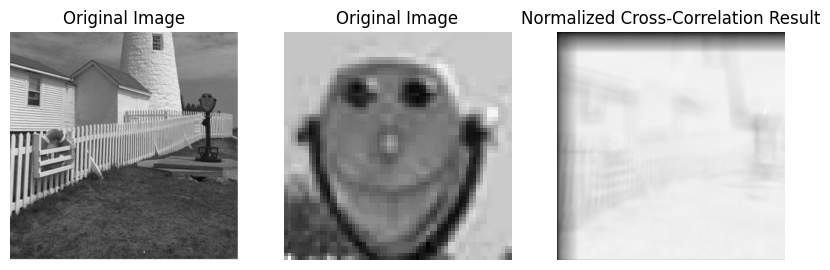

In [29]:
corr_img = norm_corr(np.array(lighthouse)/255,np.array(template)/255)
plt.figure(figsize=(10, 8))
plt.subplot(1, 3, 1)
plt.imshow(lighthouse, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(template, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(corr_img, cmap='gray')
plt.title('Normalized Cross-Correlation Result')
plt.axis('off')

plt.show()

### 2

In [30]:
def threshold_norm_cross(J, threshold):
    max_value = np.max(J)
    matches = np.where(J >= threshold)
    if len(matches[0]) > 0:
        max_match_index = np.argmax(J[matches])
        max_match = (matches[0][max_match_index], matches[1][max_match_index])
        return max_match
    else:
        return None

In [31]:
matches = threshold_norm_cross(corr_img,255)
print("Matches:", matches)

Matches: (241, 631)


### 3

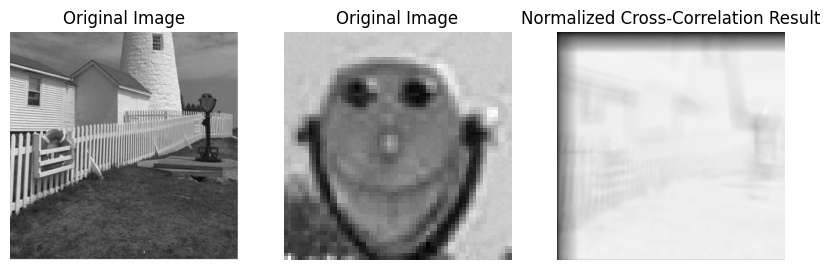

Threshold:254.9841569704274 Sigma: 1, Matches: (241, 631)


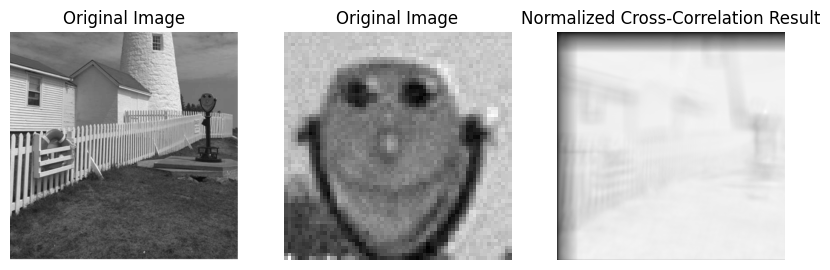

Threshold:254.86174572302548 Sigma: 3, Matches: (241, 631)


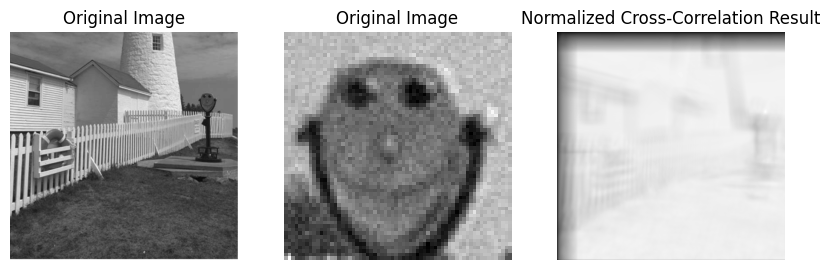

Threshold:254.6207356328588 Sigma: 5, Matches: (241, 631)


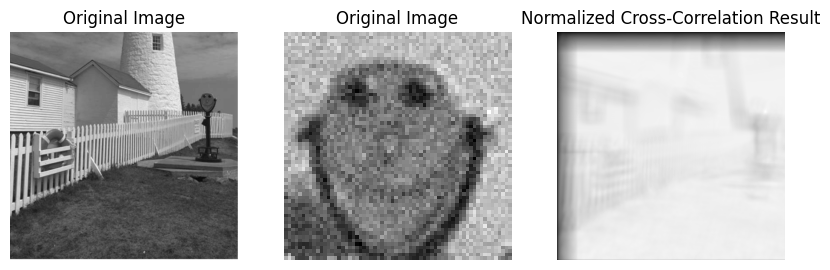

Threshold:253.42147194839757 Sigma: 10, Matches: (241, 631)


In [32]:
sigmas = [1, 3, 5, 10]

for sigma in sigmas:
    noisy_template = awgn(np.array(template), 0, sigma)
    temp = norm_corr(np.array(lighthouse)/255, noisy_template/255)
    thresh = np.max(temp)
    matches = threshold_norm_cross(temp,thresh)
    plt.figure(figsize=(10, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(lighthouse, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(noisy_template, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(temp, cmap='gray')
    plt.title('Normalized Cross-Correlation Result')
    plt.axis('off')

    plt.show()
    
    print(f"Threshold:{thresh} Sigma: {sigma}, Matches: {matches}")

<p>we can see all give same location for matching but threshold decreases as sigma increases since noise is added we cant find perfect matching so threshold decreased</p>

### 4

In [33]:
def rotate_img(I, theta):
    theta_rad = np.radians(theta)
    c, s = np.cos(theta_rad), np.sin(theta_rad)
    R = np.array([[c, -s], [s, c]])
    h, w = I.shape[:2]
    new_w = int(w * abs(c) + h * abs(s))
    new_h = int(w * abs(s) + h * abs(c))
    cx, cy = w // 2, h // 2
    rotated_img = np.zeros((new_h, new_w), dtype=I.dtype)

    for i in range(h):
        for j in range(w):
            x, y = j - cx, i - cy
            new_x, new_y = np.dot(R, [x, y]) + [new_w // 2, new_h // 2]
            new_x, new_y = int(new_x), int(new_y)
            if 0 <= new_x < new_w and 0 <= new_y < new_h:
                rotated_img[new_y, new_x] = I[i, j]

    for i in range(new_h):
        for j in range(new_w):
            if rotated_img[i, j] == 0:
                rotated_img[i, j] = 255 
                
    return rotated_img

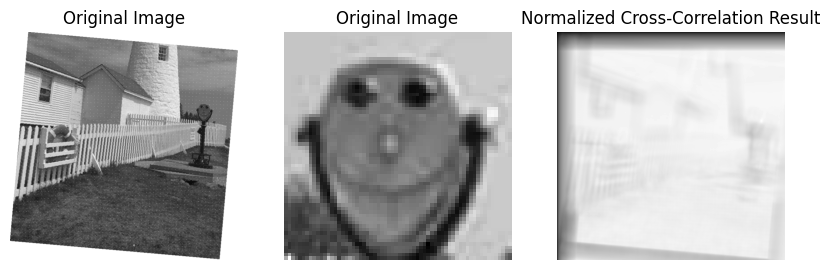

For angle 5 degrees ,Threshold: 250.25784292232566, Matches: (291, 670)


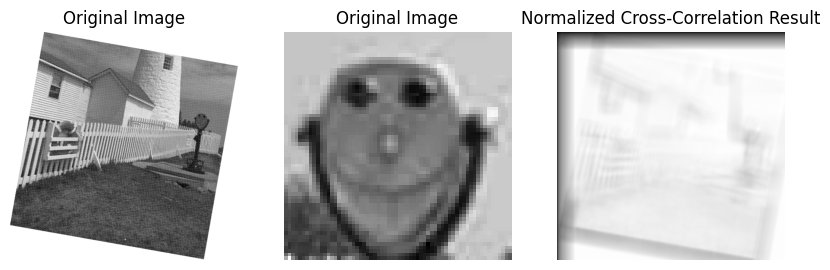

For angle 10 degrees ,Threshold: 243.22492561712698, Matches: (164, 799)


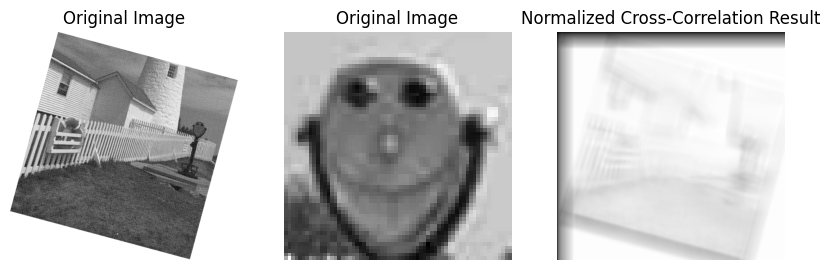

For angle 15 degrees ,Threshold: 243.07056083132898, Matches: (220, 845)


In [34]:
rotations = [5, 10, 15]

for angle in rotations:
    rotated_img = rotate_img(np.array(lighthouse),angle)/255
    corr_img = norm_corr(rotated_img,np.array(template)/255)
    mx = np.max(corr_img)
    matches = threshold_norm_cross(corr_img,mx)
    plt.figure(figsize=(10, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(rotated_img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(template, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(corr_img, cmap='gray')
    plt.title('Normalized Cross-Correlation Result')
    plt.axis('off')

    plt.show()
    print(f"For angle {angle} degrees ,Threshold: {mx}, Matches: {matches}")

<p>as angle increases we can see threshold decreases as there is less match</p>